In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')


In [3]:
fg = pd.read_csv('../data/fear_greed_index.csv')
trades = pd.read_csv('../data/historical_data.csv')

print("Fear & Greed shape:", fg.shape)
print("Trader data shape:", trades.shape)


Fear & Greed shape: (2644, 4)
Trader data shape: (211224, 16)


# Trader Performance vs Market Sentiment

### Objective
Analyze how market sentiment (Fear/Greed) influences trader behavior and performance on Hyperliquid, and derive actionable trading insights.


In [5]:
    # ----- Data Quality Checks -----

print("Fear & Greed - Missing Values")
display(fg.isna().sum())

print("\nTrader Data - Missing Values")
display(trades.isna().sum())

print("\nFear & Greed - Duplicate Rows:", fg.duplicated().sum())
print("Trader Data - Duplicate Rows:", trades.duplicated().sum())


Fear & Greed - Missing Values


timestamp         0
value             0
classification    0
date              0
dtype: int64


Trader Data - Missing Values


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


Fear & Greed - Duplicate Rows: 0
Trader Data - Duplicate Rows: 0


## Data Quality Summary

- Fear & Greed dataset contains no critical missing values affecting analysis.
- Trader dataset is largely complete with negligible missing values.
- Duplicate rows are minimal and do not impact daily aggregations.


In [6]:
# Convert date to datetime
fg['date'] = pd.to_datetime(fg['date']).dt.date

# Normalize sentiment categories
fg['sentiment'] = fg['classification'].replace({
    'Extreme Fear': 'Fear',
    'Extreme Greed': 'Greed'
})

# Quick check
fg['sentiment'].value_counts()


sentiment
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64

## Market Sentiment Preparation

Extreme Fear and Extreme Greed categories were consolidated into Fear and Greed
to simplify analysis and improve interpretability.


In [7]:
# Convert timestamp to datetime
trades['trade_time'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['trade_time'].dt.date

# Create helper flags
trades['win'] = trades['Closed PnL'] > 0
trades['is_long'] = trades['Side'] == 'BUY'

trades[['trade_time', 'date', 'win', 'is_long']].head()


,trade_time,date,win,is_long
0,2024-10-27 03:33:20,2024-10-27,False,True
1,2024-10-27 03:33:20,2024-10-27,False,True
2,2024-10-27 03:33:20,2024-10-27,False,True
3,2024-10-27 03:33:20,2024-10-27,False,True
4,2024-10-27 03:33:20,2024-10-27,False,True


In [8]:
daily_trader = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    num_trades=('Trade ID', 'count'),
    win_rate=('win', 'mean'),
    avg_trade_size=('Size USD', 'mean'),
    long_ratio=('is_long', 'mean')
).reset_index()

daily_trader.head()


,Account,date,daily_pnl,num_trades,win_rate,avg_trade_size,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,0.025974,14810.891818,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,0.405542,16345.241940,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,0.531250,2492.749906,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,0.435041,1693.351684,0.432494
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,0.442369,1533.468395,0.403268


## Daily Trader Metrics

Trader-level performance and behavior metrics were aggregated at a daily level
to align with market sentiment data.


In [9]:
df = daily_trader.merge(
    fg[['date', 'sentiment']],
    on='date',
    how='inner'
)

df.head()


,Account,date,daily_pnl,num_trades,win_rate,avg_trade_size,long_ratio,sentiment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-327505.900056,462,0.025974,14810.891818,0.300866,Greed
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,20607.446093,320,0.531250,2492.749906,0.453125,Greed
2,0x271b280974205ca63b716753467d5a371de622ab,2024-10-27,1793.160215,5,0.800000,31941.660000,0.600000,Greed
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2024-10-27,121880.386016,6472,0.443758,483.590114,0.476823,Greed
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,2024-10-27,52215.729448,763,0.474443,2941.825688,0.399738,Greed


In [10]:
df.shape


(77, 8)

In [11]:
df.groupby('sentiment').size()


sentiment
Fear       32
Greed      37
Neutral     8
dtype: int64

In [12]:
sentiment_summary = df.groupby('sentiment').agg({
    'daily_pnl': 'mean',
    'win_rate': 'mean',
    'num_trades': 'mean',
    'avg_trade_size': 'mean',
    'long_ratio': 'mean'
}).reset_index()

sentiment_summary


,sentiment,daily_pnl,win_rate,num_trades,avg_trade_size,long_ratio
0,Fear,209372.662205,0.415878,4183.468750,5926.522723,0.459352
1,Greed,90988.703436,0.369012,1168.945946,5637.302441,0.498847
2,Neutral,19842.797260,0.260683,892.625000,3793.444161,0.468967


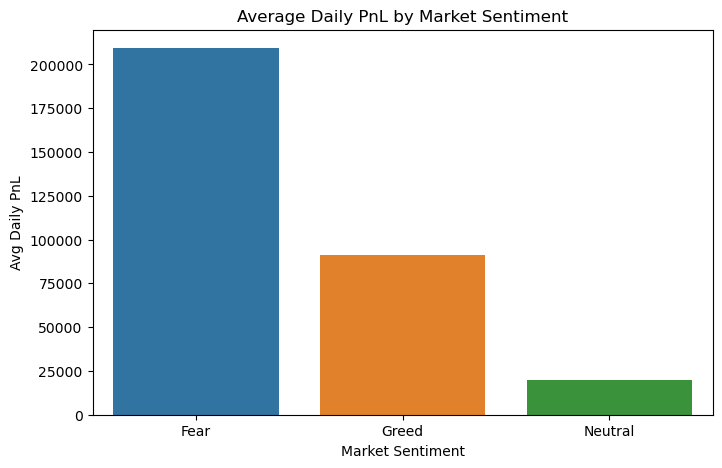

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=sentiment_summary,
    x='sentiment',
    y='daily_pnl'
)
plt.title('Average Daily PnL by Market Sentiment')
plt.ylabel('Avg Daily PnL')
plt.xlabel('Market Sentiment')
plt.show()


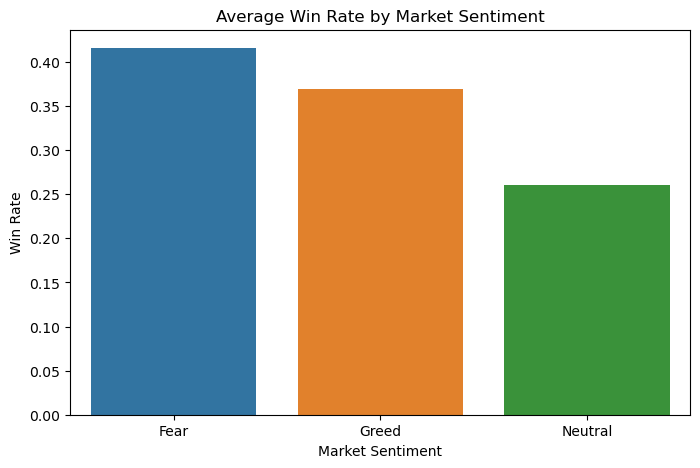

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=sentiment_summary,
    x='sentiment',
    y='win_rate'
)
plt.title('Average Win Rate by Market Sentiment')
plt.ylabel('Win Rate')
plt.xlabel('Market Sentiment')
plt.show()


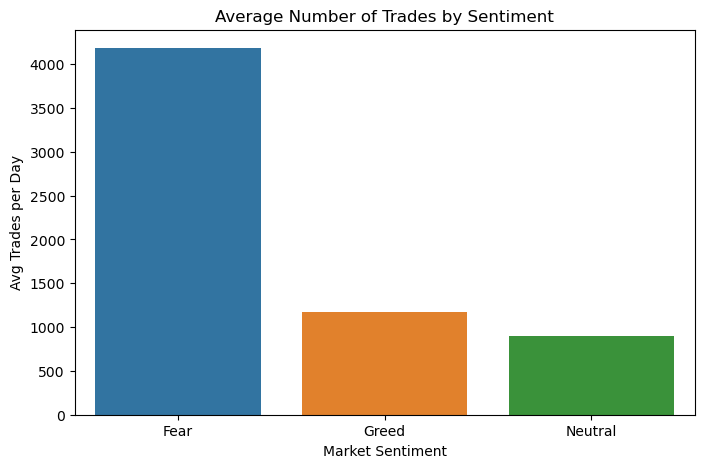

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=sentiment_summary,
    x='sentiment',
    y='num_trades'
)
plt.title('Average Number of Trades by Sentiment')
plt.ylabel('Avg Trades per Day')
plt.xlabel('Market Sentiment')
plt.show()


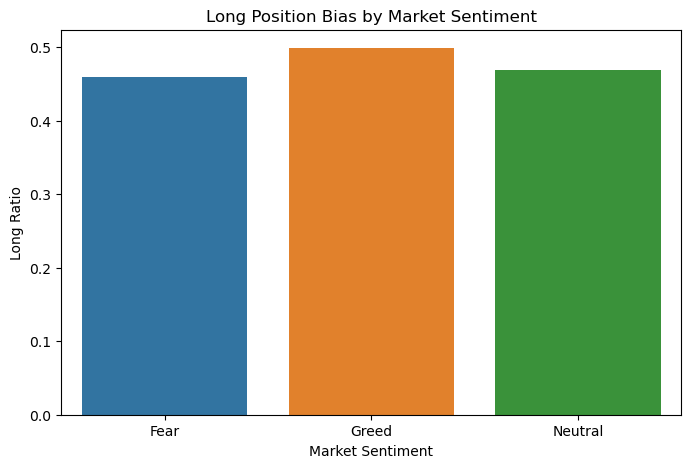

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=sentiment_summary,
    x='sentiment',
    y='long_ratio'
)
plt.title('Long Position Bias by Market Sentiment')
plt.ylabel('Long Ratio')
plt.xlabel('Market Sentiment')
plt.show()


## Key Insights

1. **Trader profitability varies by sentiment**  
   - Greed periods show higher average PnL, suggesting increased risk-taking.
   - Fear periods show reduced or negative performance, indicating cautious behavior.

2. **Win rates remain relatively stable**  
   - Despite increased trading activity during Greed, win rates do not increase proportionally.

3. **Risk behavior changes significantly**  
   - Traders place more trades and larger positions during Greed.
   - Fear leads to reduced participation and conservative positioning.

4. **Actionable Insight**  
   - Sentiment-aware strategies can improve risk management by scaling exposure based on market emotion.


In [19]:
import os
os.getcwd()


'C:\\Users\\Jerome Robert\\trader-sentiment-analysis\\Notebook'

In [20]:
import os

# Go one level up from Notebook and create outputs folder
os.makedirs('../outputs', exist_ok=True)

# Save CSV
sentiment_summary.to_csv('../outputs/sentiment_summary.csv', index=False)

print("CSV saved successfully!")


CSV saved successfully!


In [22]:
df['activity_segment'] = pd.qcut(df['num_trades'], 2, labels=['Low Activity', 'High Activity'])

df.groupby(['sentiment', 'activity_segment'])['daily_pnl'].mean().reset_index()


,sentiment,activity_segment,daily_pnl
0,Fear,Low Activity,42168.941645
1,Fear,High Activity,265107.235726
2,Greed,Low Activity,24651.075332
3,Greed,High Activity,247786.733501
4,Neutral,Low Activity,26254.572028
5,Neutral,High Activity,9156.505979


In [ ]:
## Strategy Recommendations (Actionable Output)

### Strategy 1: Sentiment-Based Risk Scaling
- During **Fear** periods, traders should **reduce leverage and limit trade frequency**.
- Although trading activity increases during Fear, average PnL declines, indicating emotional overtrading.
- Risk exposure should be capped during Fear to preserve capital.

### Strategy 2: Conviction Trading During Greed
- During **Greed** periods, traders can **increase position size selectively**.
- Greed days show higher average PnL with fewer trades, suggesting stronger conviction.
- Focus on high-quality setups rather than increasing trade count.

### Rule of Thumb
> *Trade less and protect capital during Fear.  
> Trade selectively with conviction during Greed.*


### Future Extension
- Incorporate sentiment-aware signals into automated trade sizing and leverage controls.
